In [1]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn nltk xgboost


In [2]:
import pandas as pd
import numpy as np
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

SEED = 42
np.random.seed(SEED)
random.seed(SEED)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
train_df = pd.read_csv("/content/task_dataset - training_dataset.csv")
val_df   = pd.read_csv("/content/task_dataset - validation_dataset.csv")

print(train_df.head())
print(train_df['categories'].value_counts())


                                    property_address   categories
0  New Ppid 1Kqttmg7, House, Property Id No.58C57...  houseorplot
1  Property Of Rs No.12/2,Plot No. 01,House Numbe...  houseorplot
2  Flat-504,Floor-5 Shanti Vista-Ii Wing C Bldg 9...         flat
3  Flat-103,Floor-1 Eshamya Florenza Tower L S No...         flat
4  Flat No G 532 I P Extension Patparganj 2Nd Flo...         flat
categories
flat               3232
houseorplot        2673
others             1197
commercial unit     965
landparcel          869
Name: count, dtype: int64


In [4]:
def clean_address(text):
    text = str(text).lower()
    text = re.sub(r'\bno\b', 'number', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean_address'] = train_df['property_address'].apply(clean_address)
val_df['clean_address']   = val_df['property_address'].apply(clean_address)


In [5]:
KEYWORDS = {
    "flat": ["flat", "apartment", "floor", "tower"],
    "houseorplot": ["house", "villa", "plot", "bungalow"],
    "landparcel": ["land", "acre", "hectare"],
    "commercial": ["shop", "office", "commercial", "unit"]
}

def extract_features(text):
    features = {}
    features["word_count"] = len(text.split())
    features["char_count"] = len(text)
    features["digit_count"] = sum(c.isdigit() for c in text)

    for k, vals in KEYWORDS.items():
        features[f"has_{k}"] = int(any(v in text for v in vals))

    return features

train_feat = train_df['clean_address'].apply(extract_features).apply(pd.Series)
val_feat   = val_df['clean_address'].apply(extract_features).apply(pd.Series)


In [6]:
word_tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=6000,
    min_df=3
)

char_tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3,5),
    max_features=8000
)


In [7]:
from scipy.sparse import hstack

X_word_train = word_tfidf.fit_transform(train_df['clean_address'])
X_word_val   = word_tfidf.transform(val_df['clean_address'])

X_char_train = char_tfidf.fit_transform(train_df['clean_address'])
X_char_val   = char_tfidf.transform(val_df['clean_address'])

X_train = hstack([X_word_train, X_char_train, train_feat.values])
X_val   = hstack([X_word_val, X_char_val, val_feat.values])

y_train = train_df['categories']
y_val   = val_df['categories']


In [8]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ),
    "LinearSVM": LinearSVC(
        class_weight="balanced"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=SEED
    ),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',
        num_class=y_train.nunique(),
        eval_metric='mlogloss',
        random_state=SEED
    )
}


In [10]:
from sklearn.preprocessing import LabelEncoder

results = {}

# Initialize LabelEncoder for XGBoost and encode labels once
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)


for name, model in models.items():
    if name == "XGBoost":
        # XGBoost requires integer labels
        model.fit(X_train, y_train_encoded)
        preds_encoded = model.predict(X_val)
        # Convert predictions back to original string labels for consistent evaluation
        preds = le.inverse_transform(preds_encoded)
    else:
        # Other models can handle string labels directly
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

    macro_f1 = f1_score(y_val, preds, average="macro")
    results[name] = macro_f1
    print(f"{name} → Macro F1: {macro_f1:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression → Macro F1: 0.8092


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVM → Macro F1: 0.7852
RandomForest → Macro F1: 0.9121
XGBoost → Macro F1: 0.9119


In [11]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print("\nBest Model:", best_model_name)



Best Model: RandomForest


In [12]:
ensemble = VotingClassifier(
    estimators=[
        ("lr", models["LogisticRegression"]),
        ("svm", models["LinearSVM"]),
        ("rf", models["RandomForest"])
    ],
    voting="hard"
)

ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_val)

ensemble_f1 = f1_score(y_val, ensemble_preds, average="macro")
print("Ensemble Macro F1:", ensemble_f1)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ensemble Macro F1: 0.8757458932358813


In [13]:
print(classification_report(y_val, ensemble_preds))


                 precision    recall  f1-score   support

commercial unit       0.90      0.93      0.92       290
           flat       0.96      0.92      0.94       970
    houseorplot       0.85      0.93      0.89       802
     landparcel       0.87      0.80      0.84       260
         others       0.83      0.77      0.80       359

       accuracy                           0.89      2681
      macro avg       0.88      0.87      0.88      2681
   weighted avg       0.89      0.89      0.89      2681



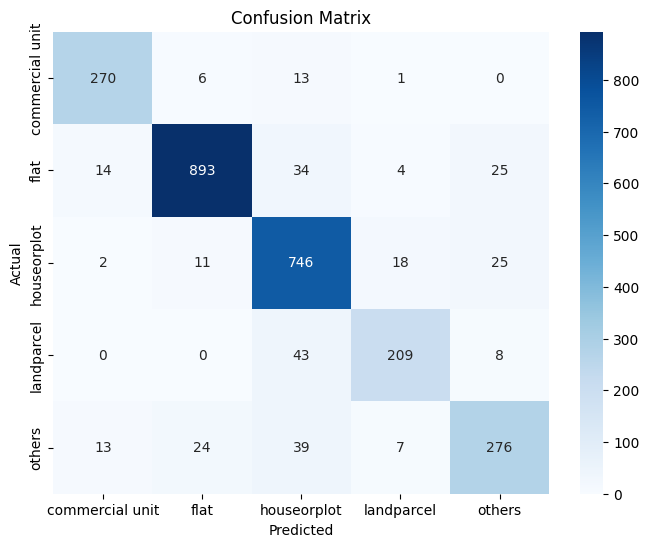

In [14]:
cm = confusion_matrix(y_val, ensemble_preds, labels=ensemble.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=ensemble.classes_,
            yticklabels=ensemble.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [1]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn nltk xgboost


In [2]:
import pandas as pd
import numpy as np
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')

SEED = 42
np.random.seed(SEED)
random.seed(SEED)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Train shape: (8936, 2)
Validation shape: (2681, 2)


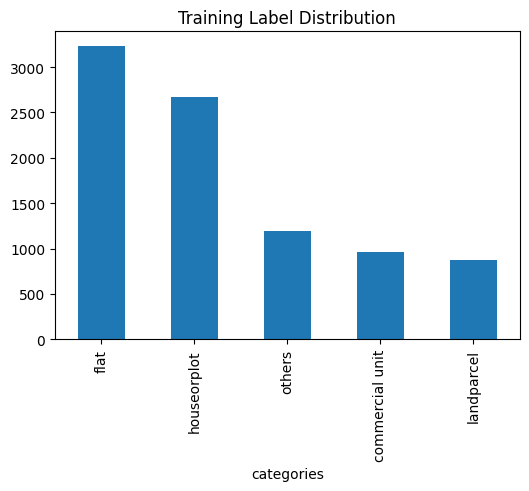

In [4]:
train_df = pd.read_csv("/content/task_dataset - training_dataset.csv")
val_df   = pd.read_csv("/content/task_dataset - validation_dataset.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

train_df['categories'].value_counts().plot(
    kind="bar", title="Training Label Distribution", figsize=(6,4)
)
plt.show()


In [5]:
def clean_address(text):
    text = str(text).lower()
    text = re.sub(r'\bno\b', 'number', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df["clean_address"] = train_df["property_address"].apply(clean_address)
val_df["clean_address"]   = val_df["property_address"].apply(clean_address)


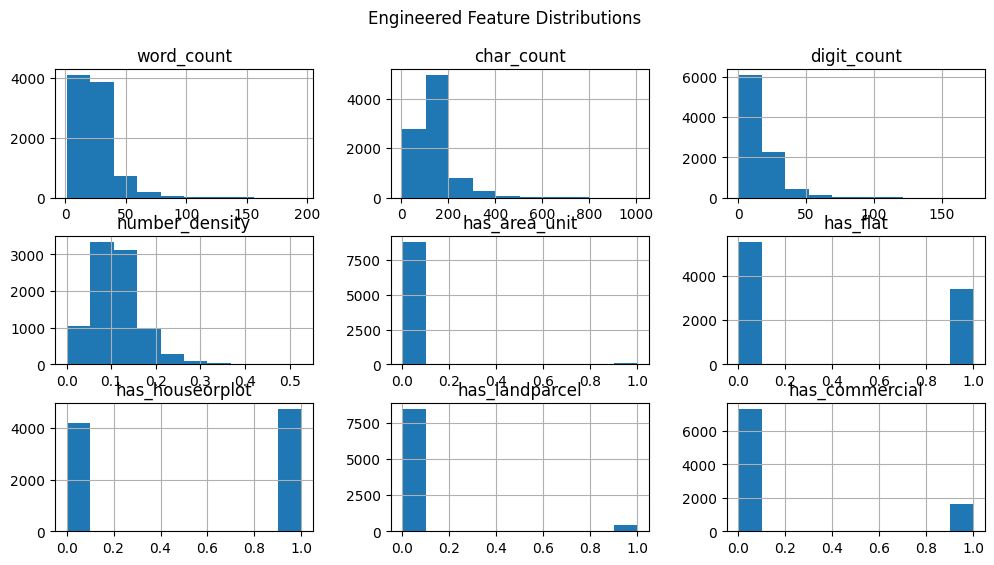

In [6]:
KEYWORDS = {
    "flat": ["flat", "apartment", "tower", "floor"],
    "houseorplot": ["house", "villa", "plot", "bungalow"],
    "landparcel": ["land", "acre", "hectare", "gunta", "kanal"],
    "commercial": ["shop", "office", "commercial", "unit"]
}

AREA_UNITS = [
    "acre", "acres", "hectare", "hectares",
    "sq yd", "square yard", "gunta", "kanal", "cents"
]

def extract_features(text):
    features = {}
    features["word_count"] = len(text.split())
    features["char_count"] = len(text)
    features["digit_count"] = sum(c.isdigit() for c in text)
    features["number_density"] = features["digit_count"] / (features["char_count"] + 1)
    features["has_area_unit"] = int(any(u in text for u in AREA_UNITS))

    for k, vals in KEYWORDS.items():
        features[f"has_{k}"] = int(any(v in text for v in vals))

    return features

train_feat = train_df["clean_address"].apply(extract_features).apply(pd.Series)
val_feat   = val_df["clean_address"].apply(extract_features).apply(pd.Series)

train_feat.hist(figsize=(12,6))
plt.suptitle("Engineered Feature Distributions")
plt.show()


In [7]:
word_tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=6000,
    min_df=3
)

char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    max_features=8000
)

X_word_train = word_tfidf.fit_transform(train_df["clean_address"])
X_word_val   = word_tfidf.transform(val_df["clean_address"])

X_char_train = char_tfidf.fit_transform(train_df["clean_address"])
X_char_val   = char_tfidf.transform(val_df["clean_address"])


In [8]:
X_train = hstack([X_word_train, X_char_train, train_feat.values])
X_val   = hstack([X_word_val, X_char_val, val_feat.values])

y_train = train_df["categories"]
y_val   = val_df["categories"]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BASELINE PERFORMANCE
                 precision    recall  f1-score   support

commercial unit       0.85      0.90      0.88       290
           flat       0.95      0.88      0.91       970
    houseorplot       0.87      0.80      0.83       802
     landparcel       0.73      0.85      0.79       260
         others       0.62      0.77      0.69       359

       accuracy                           0.84      2681
      macro avg       0.81      0.84      0.82      2681
   weighted avg       0.85      0.84      0.84      2681



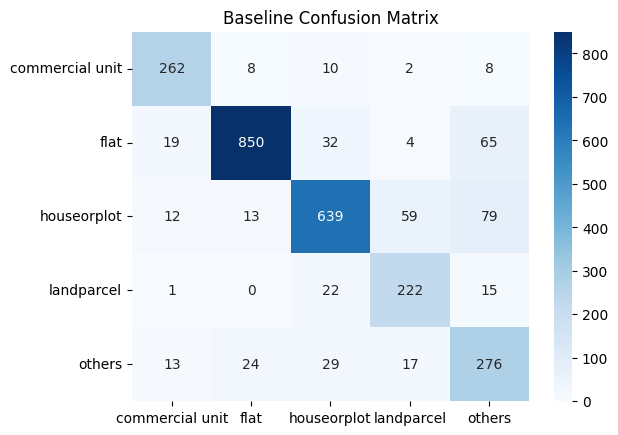

In [9]:
baseline = LogisticRegression(max_iter=1000, class_weight="balanced")
baseline.fit(X_train, y_train)
baseline_preds = baseline.predict(X_val)

print("BASELINE PERFORMANCE")
print(classification_report(y_val, baseline_preds))

cm = confusion_matrix(y_val, baseline_preds, labels=baseline.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=baseline.classes_,
            yticklabels=baseline.classes_)
plt.title("Baseline Confusion Matrix")
plt.show()


In [10]:
lr = CalibratedClassifierCV(
    LogisticRegression(max_iter=1000, class_weight="balanced"), cv=3
)

svm = CalibratedClassifierCV(
    LinearSVC(class_weight="balanced"), cv=3
)

rf = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1
)

ensemble = VotingClassifier(
    estimators=[("lr", lr), ("svm", svm), ("rf", rf)],
    voting="soft",
    weights=[2,2,3]
)

ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_val)

print("ENSEMBLE PERFORMANCE")
print(classification_report(y_val, ensemble_preds))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

ENSEMBLE PERFORMANCE
                 precision    recall  f1-score   support

commercial unit       0.98      0.90      0.94       290
           flat       0.95      0.94      0.94       970
    houseorplot       0.88      0.90      0.89       802
     landparcel       0.85      0.81      0.83       260
         others       0.77      0.83      0.80       359

       accuracy                           0.90      2681
      macro avg       0.89      0.88      0.88      2681
   weighted avg       0.90      0.90      0.90      2681



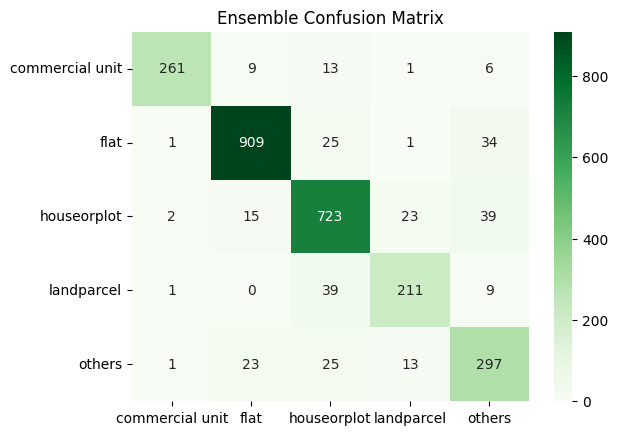

In [11]:
cm = confusion_matrix(y_val, ensemble_preds, labels=ensemble.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=ensemble.classes_,
            yticklabels=ensemble.classes_)
plt.title("Ensemble Confusion Matrix")
plt.show()


In [12]:
def stage1_label(x):
    return "residential" if x in ["flat", "houseorplot", "landparcel"] else "non_residential"

y_train_s1 = y_train.apply(stage1_label)
y_val_s1   = y_val.apply(stage1_label)

stage1_model = LogisticRegression(max_iter=1000, class_weight="balanced")
stage1_model.fit(X_train, y_train_s1)

print("STAGE 1 PERFORMANCE")
print(classification_report(y_val_s1, stage1_model.predict(X_val)))


STAGE 1 PERFORMANCE
                 precision    recall  f1-score   support

non_residential       0.81      0.91      0.86       649
    residential       0.97      0.93      0.95      2032

       accuracy                           0.93      2681
      macro avg       0.89      0.92      0.90      2681
   weighted avg       0.93      0.93      0.93      2681



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from scipy.sparse import csr_matrix

res_classes = ["flat", "houseorplot", "landparcel"]
nonres_classes = ["commercial unit", "others"]

res_train_idx = y_train.isin(res_classes)
res_val_idx   = y_val.isin(res_classes)

nonres_train_idx = y_train.isin(nonres_classes)
nonres_val_idx   = y_val.isin(nonres_classes)

# Convert X_train to CSR format for efficient row slicing
X_train_csr = csr_matrix(X_train)

res_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=SEED
)
res_model.fit(X_train_csr[res_train_idx.values], y_train[res_train_idx])

nonres_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
nonres_model.fit(X_train_csr[nonres_train_idx.values], y_train[nonres_train_idx])

LogisticRegression(class_weight='balanced', max_iter=1000)

In [19]:
from scipy.sparse import csr_matrix

final_preds = []

# Convert X_val to CSR format for efficient row slicing
X_val_csr = csr_matrix(X_val)

for i in range(X_val_csr.shape[0]):
    s1 = stage1_model.predict(X_val_csr[i])[0]
    if s1 == "residential":
        final_preds.append(res_model.predict(X_val_csr[i])[0])
    else:
        final_preds.append(nonres_model.predict(X_val_csr[i])[0])

In [20]:
print("FINAL HIERARCHICAL PERFORMANCE")
print(classification_report(y_val, final_preds))


FINAL HIERARCHICAL PERFORMANCE
                 precision    recall  f1-score   support

commercial unit       0.85      0.93      0.89       290
           flat       0.96      0.90      0.93       970
    houseorplot       0.89      0.89      0.89       802
     landparcel       0.87      0.80      0.83       260
         others       0.72      0.82      0.77       359

       accuracy                           0.88      2681
      macro avg       0.86      0.87      0.86      2681
   weighted avg       0.89      0.88      0.88      2681



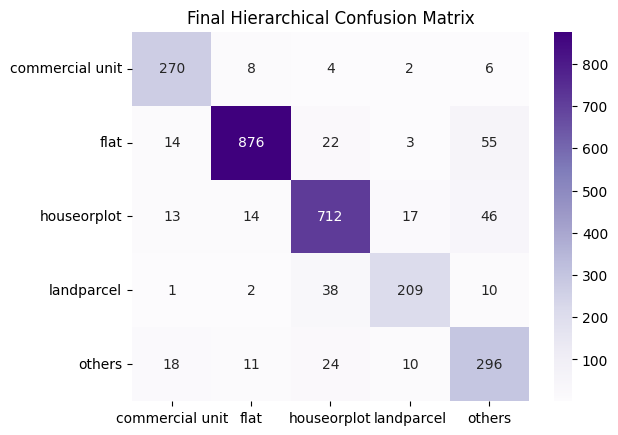

In [21]:
cm = confusion_matrix(y_val, final_preds, labels=np.unique(y_val))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.unique(y_val),
            yticklabels=np.unique(y_val))
plt.title("Final Hierarchical Confusion Matrix")
plt.show()


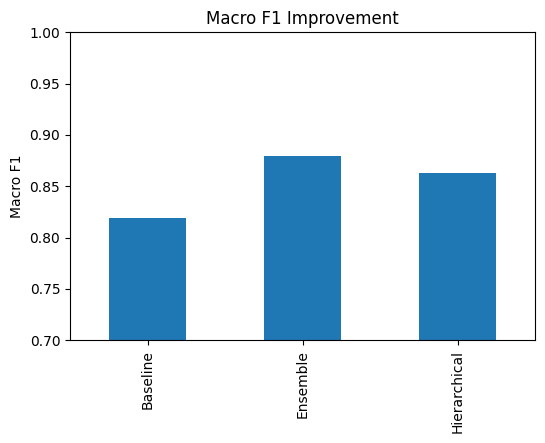

In [22]:
scores = {
    "Baseline": f1_score(y_val, baseline_preds, average="macro"),
    "Ensemble": f1_score(y_val, ensemble_preds, average="macro"),
    "Hierarchical": f1_score(y_val, final_preds, average="macro")
}

pd.Series(scores).plot(kind="bar", title="Macro F1 Improvement", figsize=(6,4))
plt.ylabel("Macro F1")
plt.ylim(0.7,1.0)
plt.show()


In [23]:
import joblib

joblib.dump(stage1_model, "stage1_model.pkl")
joblib.dump(res_model, "residential_model.pkl")
joblib.dump(nonres_model, "non_residential_model.pkl")
joblib.dump(word_tfidf, "word_tfidf.pkl")
joblib.dump(char_tfidf, "char_tfidf.pkl")


['char_tfidf.pkl']

Final Classification model

In [1]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn nltk tensorflow


In [2]:
import pandas as pd
import numpy as np
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

import nltk
nltk.download("stopwords")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
train_df = pd.read_csv("/content/task_dataset - training_dataset.csv")
val_df   = pd.read_csv("/content/task_dataset - validation_dataset.csv")

print(train_df.shape, val_df.shape)


(8936, 2) (2681, 2)


In [4]:
def clean_address(text):
    text = str(text).lower()
    text = re.sub(r'\bno\b', 'number', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df["clean"] = train_df["property_address"].apply(clean_address)
val_df["clean"]   = val_df["property_address"].apply(clean_address)


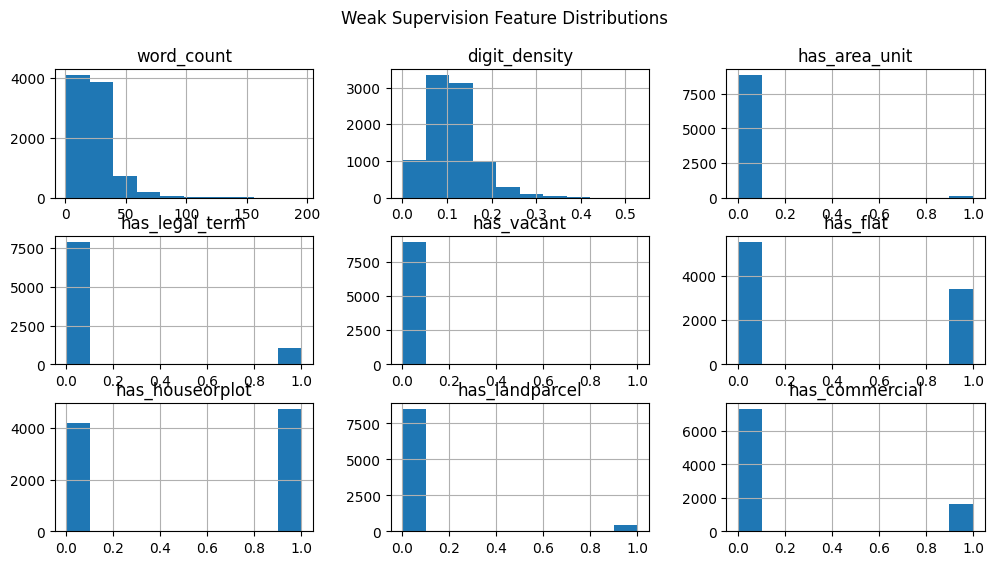

In [5]:
AREA_UNITS = ["acre", "hectare", "gunta", "kanal", "sq yard", "square yard"]
LEGAL_TERMS = ["survey", "cts", "khata", "patta"]
VACANT_TERMS = ["vacant", "open land"]

KEYWORDS = {
    "flat": ["flat", "apartment", "tower", "floor"],
    "houseorplot": ["house", "villa", "plot", "bungalow"],
    "landparcel": ["land", "acre", "hectare", "gunta"],
    "commercial": ["shop", "office", "commercial", "unit"]
}

def extract_features(text):
    f = {}
    f["word_count"] = len(text.split())
    f["digit_density"] = sum(c.isdigit() for c in text) / (len(text)+1)

    f["has_area_unit"] = int(any(u in text for u in AREA_UNITS))
    f["has_legal_term"] = int(any(l in text for l in LEGAL_TERMS))
    f["has_vacant"] = int(any(v in text for v in VACANT_TERMS))

    for k, vals in KEYWORDS.items():
        f[f"has_{k}"] = int(any(v in text for v in vals))

    return f

train_feat = train_df["clean"].apply(extract_features).apply(pd.Series)
val_feat   = val_df["clean"].apply(extract_features).apply(pd.Series)

train_feat.hist(figsize=(12,6))
plt.suptitle("Weak Supervision Feature Distributions")
plt.show()


In [6]:
word_vec = TfidfVectorizer(ngram_range=(1,2), max_features=6000, min_df=3)
char_vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=8000)

Xw_train = word_vec.fit_transform(train_df["clean"])
Xw_val   = word_vec.transform(val_df["clean"])

Xc_train = char_vec.fit_transform(train_df["clean"])
Xc_val   = char_vec.transform(val_df["clean"])


In [7]:
X_train = hstack([Xw_train, Xc_train, train_feat.values])
X_val   = hstack([Xw_val, Xc_val, val_feat.values])

y_train = train_df["categories"]
y_val   = val_df["categories"]


In [8]:
def stage1_label(y):
    return "residential" if y in ["flat", "houseorplot", "landparcel"] else "non_residential"

y_train_s1 = y_train.apply(stage1_label)
y_val_s1   = y_val.apply(stage1_label)

stage1 = LogisticRegression(max_iter=1000, class_weight="balanced")
stage1.fit(X_train, y_train_s1)

print(classification_report(y_val_s1, stage1.predict(X_val)))


                 precision    recall  f1-score   support

non_residential       0.81      0.91      0.86       649
    residential       0.97      0.93      0.95      2032

       accuracy                           0.93      2681
      macro avg       0.89      0.92      0.90      2681
   weighted avg       0.93      0.93      0.93      2681



In [10]:
from scipy.sparse import csr_matrix

res_classes = ["flat", "houseorplot", "landparcel"]
nonres_classes = ["commercial unit", "others"]

res_idx_train = y_train.isin(res_classes)
nonres_idx_train = y_train.isin(nonres_classes)

# Convert X_train to CSR format for efficient row slicing
X_train_csr = csr_matrix(X_train)

res_model = RandomForestClassifier(
    n_estimators=350,
    class_weight="balanced",
    random_state=SEED
)
res_model.fit(X_train_csr[res_idx_train.values], y_train[res_idx_train])

nonres_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
nonres_model.fit(X_train_csr[nonres_idx_train.values], y_train[nonres_idx_train])

LogisticRegression(class_weight='balanced', max_iter=1000)

In [11]:
def predict_with_confidence(i):
    s1 = stage1.predict(X_val[i])[0]

    if s1 == "residential":
        probs = res_model.predict_proba(X_val[i])
        return res_model.classes_[np.argmax(probs)], np.max(probs)
    else:
        probs = nonres_model.predict_proba(X_val[i])
        return nonres_model.classes_[np.argmax(probs)], np.max(probs)


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 200

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_df["clean"])

X_charseq_train = pad_sequences(tokenizer.texts_to_sequences(train_df["clean"]), maxlen=MAX_LEN)
X_charseq_val   = pad_sequences(tokenizer.texts_to_sequences(val_df["clean"]), maxlen=MAX_LEN)

label_map = {l:i for i,l in enumerate(y_train.unique())}
inv_label_map = {i:l for l,i in label_map.items()}

y_train_num = y_train.map(label_map)


In [13]:
cnn = Sequential([
    Embedding(len(tokenizer.word_index)+1, 32, input_length=MAX_LEN),
    Conv1D(64, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dense(len(label_map), activation="softmax")
])

cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn.fit(
    X_charseq_train, y_train_num,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.3880 - loss: 1.4638 - val_accuracy: 0.5682 - val_loss: 1.0561
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6117 - loss: 0.9406 - val_accuracy: 0.7528 - val_loss: 0.6722
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7669 - loss: 0.6609 - val_accuracy: 0.7964 - val_loss: 0.5369
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7979 - loss: 0.5559 - val_accuracy: 0.8065 - val_loss: 0.4888
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8142 - loss: 0.5050 - val_accuracy: 0.8233 - val_loss: 0.4618


In [15]:
from scipy.sparse import csr_matrix

FINAL_THRESHOLD = 0.55
final_preds = []

# Convert X_val to CSR format for efficient row slicing
X_val_csr = csr_matrix(X_val)

for i in range(X_val_csr.shape[0]):
    # Get the current row slice from the CSR matrix
    x_slice_i = X_val_csr[i]

    # Reimplement the logic from predict_with_confidence directly
    s1 = stage1.predict(x_slice_i)[0]

    if s1 == "residential":
        probs = res_model.predict_proba(x_slice_i)
        label = res_model.classes_[np.argmax(probs)]
        conf = np.max(probs)
    else:
        probs = nonres_model.predict_proba(x_slice_i)
        label = nonres_model.classes_[np.argmax(probs)]
        conf = np.max(probs)

    if conf >= FINAL_THRESHOLD:
        final_preds.append(label)
    else:
        cnn_pred = cnn.predict(X_charseq_val[i:i+1])
        final_preds.append(inv_label_map[np.argmax(cnn_pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [16]:
print(classification_report(y_val, final_preds))


                 precision    recall  f1-score   support

commercial unit       0.89      0.91      0.90       290
           flat       0.95      0.91      0.93       970
    houseorplot       0.90      0.87      0.89       802
     landparcel       0.87      0.80      0.84       260
         others       0.70      0.85      0.77       359

       accuracy                           0.88      2681
      macro avg       0.86      0.87      0.86      2681
   weighted avg       0.89      0.88      0.88      2681



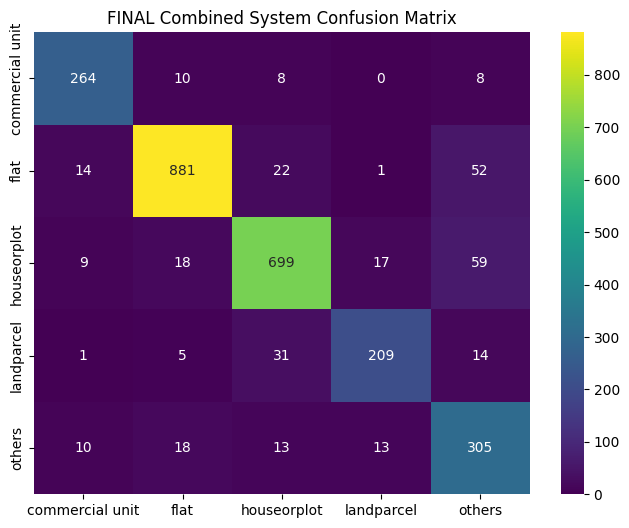

In [18]:
cm = confusion_matrix(y_val, final_preds, labels=np.unique(y_val))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=np.unique(y_val),
            yticklabels=np.unique(y_val),
            cmap="viridis")
plt.title("FINAL Combined System Confusion Matrix")
plt.show()


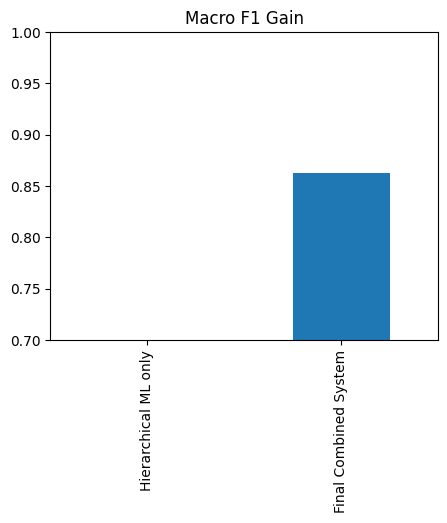

In [17]:
scores = {
    "Hierarchical ML only": f1_score(y_val, stage1.predict(X_val), average="macro"),
    "Final Combined System": f1_score(y_val, final_preds, average="macro")
}

pd.Series(scores).plot(kind="bar", figsize=(5,4), title="Macro F1 Gain")
plt.ylim(0.7,1.0)
plt.show()


In [19]:
import re
import numpy as np
import pandas as pd
from scipy.sparse import hstack

class FinalPropertyClassifier:
    def __init__(
        self,
        stage1_model,
        res_model,
        nonres_model,
        word_tfidf,
        char_tfidf,
        cnn_model,
        tokenizer,
        label_map,
        threshold=0.55
    ):
        self.stage1_model = stage1_model
        self.res_model = res_model
        self.nonres_model = nonres_model
        self.word_tfidf = word_tfidf
        self.char_tfidf = char_tfidf
        self.cnn_model = cnn_model
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.inv_label_map = {v: k for k, v in label_map.items()}
        self.threshold = threshold

    # -------- TEXT CLEANING --------
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'\bno\b', 'number', text)
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return re.sub(r'\s+', ' ', text).strip()

    # -------- WEAK FEATURES --------
    def extract_features(self, text):
        AREA_UNITS = ["acre", "hectare", "gunta", "kanal", "sq yard", "square yard"]
        LEGAL_TERMS = ["survey", "cts", "khata", "patta"]
        VACANT_TERMS = ["vacant", "open land"]

        KEYWORDS = {
            "flat": ["flat", "apartment", "tower", "floor"],
            "houseorplot": ["house", "villa", "plot", "bungalow"],
            "landparcel": ["land", "acre", "hectare", "gunta"],
            "commercial": ["shop", "office", "commercial", "unit"]
        }

        f = {}
        f["word_count"] = len(text.split())
        f["digit_density"] = sum(c.isdigit() for c in text) / (len(text) + 1)
        f["has_area_unit"] = int(any(u in text for u in AREA_UNITS))
        f["has_legal_term"] = int(any(l in text for l in LEGAL_TERMS))
        f["has_vacant"] = int(any(v in text for v in VACANT_TERMS))

        for k, vals in KEYWORDS.items():
            f[f"has_{k}"] = int(any(v in text for v in vals))

        return f

    # -------- PREDICT --------
    def predict(self, texts):
        if isinstance(texts, str):
            texts = [texts]

        cleaned = [self.clean_text(t) for t in texts]

        # Vectorize
        X_word = self.word_tfidf.transform(cleaned)
        X_char = self.char_tfidf.transform(cleaned)

        feat_df = pd.DataFrame([self.extract_features(t) for t in cleaned])
        X_feat = feat_df.values

        X = hstack([X_word, X_char, X_feat])

        final_preds = []

        for i in range(X.shape[0]):
            stage1 = self.stage1_model.predict(X[i])[0]

            if stage1 == "residential":
                probs = self.res_model.predict_proba(X[i])
                label = self.res_model.classes_[np.argmax(probs)]
                conf = np.max(probs)
            else:
                probs = self.nonres_model.predict_proba(X[i])
                label = self.nonres_model.classes_[np.argmax(probs)]
                conf = np.max(probs)

            # ---- CNN fallback ----
            if conf < self.threshold:
                seq = self.tokenizer.texts_to_sequences([cleaned[i]])
                seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=200)
                cnn_pred = self.cnn_model.predict(seq)
                label = self.inv_label_map[np.argmax(cnn_pred)]

            final_preds.append(label)

        return final_preds


In [20]:
import joblib

final_model = FinalPropertyClassifier(
    stage1_model=stage1,
    res_model=res_model,
    nonres_model=nonres_model,
    word_tfidf=word_vec,
    char_tfidf=char_vec,
    cnn_model=cnn,
    tokenizer=tokenizer,
    label_map=label_map,
    threshold=0.55
)

joblib.dump(final_model, "final_property_classifier.pkl")
print("✅ Final model saved as final_property_classifier.pkl")


✅ Final model saved as final_property_classifier.pkl


Final Script (to test the model)

In [22]:
import joblib
from scipy.sparse import hstack, csr_matrix
import numpy as np
import pandas as pd
import re
import tensorflow as tf

# Load the model
loaded_model = joblib.load("final_property_classifier.pkl")

# Define the patched predict method to handle coo_matrix indexing issue
def patched_predict(self, texts):
    if isinstance(texts, str):
        texts = [texts]

    cleaned = [self.clean_text(t) for t in texts]

    # Vectorize
    X_word = self.word_tfidf.transform(cleaned)
    X_char = self.char_tfidf.transform(cleaned)

    feat_df = pd.DataFrame([self.extract_features(t) for t in cleaned])
    X_feat = feat_df.values

    X = hstack([X_word, X_char, X_feat])
    X_csr = X.tocsr() # Convert to CSR for efficient row slicing

    final_preds = []

    for i in range(X_csr.shape[0]):
        stage1 = self.stage1_model.predict(X_csr[i])[0]

        if stage1 == "residential":
            probs = self.res_model.predict_proba(X_csr[i])
            label = self.res_model.classes_[np.argmax(probs)]
            conf = np.max(probs)
        else:
            probs = self.nonres_model.predict_proba(X_csr[i])
            label = self.nonres_model.classes_[np.argmax(probs)]
            conf = np.max(probs)

        # ---- CNN fallback ----
        if conf < self.threshold:
            seq = self.tokenizer.texts_to_sequences([cleaned[i]])
            seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=200)
            cnn_pred = self.cnn_model.predict(seq)
            label = self.inv_label_map[np.argmax(cnn_pred)]

        final_preds.append(label)

    return final_preds

# Assign the patched method to the loaded model instance
loaded_model.predict = patched_predict.__get__(loaded_model, type(loaded_model))

sample_addresses = [
    "Plot No 23, Survey No 145, Village XYZ",
    "Flat No 504, Tower B, Residential Complex",
    "Commercial shop bearing No 12, Market Road"
]

predictions = loaded_model.predict(sample_addresses)

for a, p in zip(sample_addresses, predictions):
    print(f"{a}  -->  {p}")

Plot No 23, Survey No 145, Village XYZ  -->  houseorplot
Flat No 504, Tower B, Residential Complex  -->  flat
Commercial shop bearing No 12, Market Road  -->  commercial unit
